# 04.03 - Linear Regression using PyTorch

## First Steps with `PyTorch`: Loading the Data

We will be fitting a linear regression model on the data using `PyTorch`.

### Organizing the Data in Pandas for Convenience

Our prediction objective is commonly referred to as the **target** or **response variable**.

The data and the target are what we use for training, or **fitting**, the model.

In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np

# Specify the path to the diamonds dataset
diamonds_csv: str = './diamonds.csv'

# Read the dataset into a pandas DataFrame
# The DataFrame, diamonds, will hold the entire diamonds dataset
diamonds: pd.DataFrame = pd.read_csv(diamonds_csv)

# Use the .head() function to display the first 5 rows of the dataset
# This is a good practice to understand the structure of the data
diamonds.head()

# We are interested in the 'carat', 'depth', 'table', 'x', 'y', 'z' columns as our predictors
# We create a new DataFrame, df, that consists of these columns
# The 'loc' function is used to select these columns
# The 'columns' parameter is used to specify the column names in the new DataFrame
df: pd.DataFrame = pd.DataFrame(diamonds.loc[:,['carat', 'depth', 'table', 'x', 'y', 'z']], columns=['carat', 'depth', 'table', 'x', 'y', 'z'])

# Our target variable is 'price'
# We extract this column from the diamonds DataFrame and convert it to a numpy array using the .values attribute
# We then wrap this array into a pandas DataFrame for ease of use
# This DataFrame, target, will hold our target variable
price: np.ndarray = diamonds['price'].values
target: pd.DataFrame = pd.DataFrame(price)

# Print the shapes of our predictor dataset (df) and target dataset (target)
# This is to ensure that they have the correct dimensions
print(target.shape)
print(df.shape)

# Display the first 5 rows of the df DataFrame using the .head() function
# This is to inspect our predictor dataset and ensure it's structured correctly
df.head()

(53940, 1)
(53940, 6)


,carat,depth,table,x,y,z
0,0.23,61.5,55.0,3.95,3.98,2.43
1,0.21,59.8,61.0,3.89,3.84,2.31
2,0.23,56.9,65.0,4.05,4.07,2.31
3,0.29,62.4,58.0,4.20,4.23,2.63
4,0.31,63.3,58.0,4.34,4.35,2.75


Our training set is a matrix/dataframe comprised of six variables, forming our predictors. We have **6** predictors and **53940** rows/observations.

Our target is a tensor that represents a single variable (**price**), which has exactly the same number of observations as our training set: **53940**.

In PyTorch, we will use these tensors to train our model.

In [2]:
# Now we will display the first 5 rows of our target dataframe.
# This is done using the .head() function.
# The .head() function, when used without any arguments, returns the first 5 rows of the dataframe or series.
# If you want to display more or fewer rows, you can pass the desired number as an argument to the .head() function.
# For example, .head(10) will return the first 10 rows.
# This is useful for quickly inspecting the data we are working with.
target.head()

,0
0,326
1,326
2,327
3,334
4,335


### Index Correspondence Between Target and Predictors in PyTorch

Row 0 of our training data, **`df`**, is:

```python
tensor([0.23, 61.5, 55.0, 3.95, 3.98, 2.43])

```

This corresponds to the 0 index observation in our target tensor:

```python
tensor([326])

```

These two separate datasets, a matrix and a vector, are what we will use for training our model in PyTorch.

- The training data is a 2D tensor with dimensions: `n_samples` * `n_features`
- The response is a 1D tensor with dimensions: `n_samples`, matching the `n_samples` of the training data.

## Training Our First Model with PyTorch

Now, let's train a linear regression model using the diamond data in PyTorch.

First, let's visually identify some predictors that seem to have a relationship with price.

**Plot each variable in `df` against the `target` tensor.**

In [3]:
# Import necessary libraries
import matplotlib.pyplot as plt

def plot_scatter(column_name: str, df: pd.DataFrame, target: np.ndarray) -> None:
    """
    This function takes a column name, a DataFrame and a target array,
    and plots a scatter plot of the column against the target.

    Args:
    column_name (str): Name of the column in df to be plotted.
    df (pd.DataFrame): DataFrame containing the data.
    target (np.ndarray): Array containing the target values.

    Returns:
    None
    """
    # Create a new figure with specified size in inches
    fig: plt.Figure = plt.figure(figsize=(15,7))

    # Get the current Axes instance on the current figure
    ax: plt.Axes = plt.gca()

    # Plot a scatter plot on the Axes with our data.
    # The x-values are the data from the specified column in the DataFrame,
    # and the y-values are the target values.
    # The color of the points is set to blue.
    ax.scatter(df[column_name], target, c='b')

    # Set the title of the plot
    ax.set_title(f'Scatter plot of the Price of Diamond with respect to {column_name.capitalize()}')

    # Set the label for the x-axis
    ax.set_xlabel(column_name.capitalize())

    # Set the label for the y-axis
    ax.set_ylabel('Price')

    # Display the legend
    ax.legend()

    # Display the plot
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


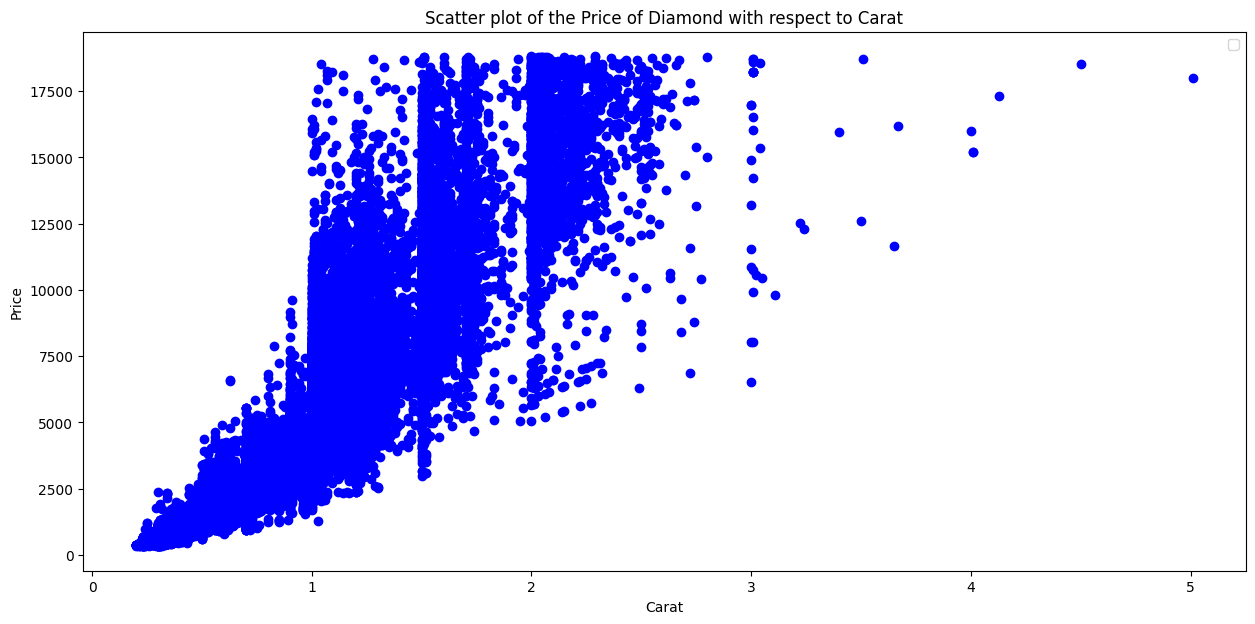

In [4]:
plot_scatter(column_name = 'carat', df = df, target = target)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


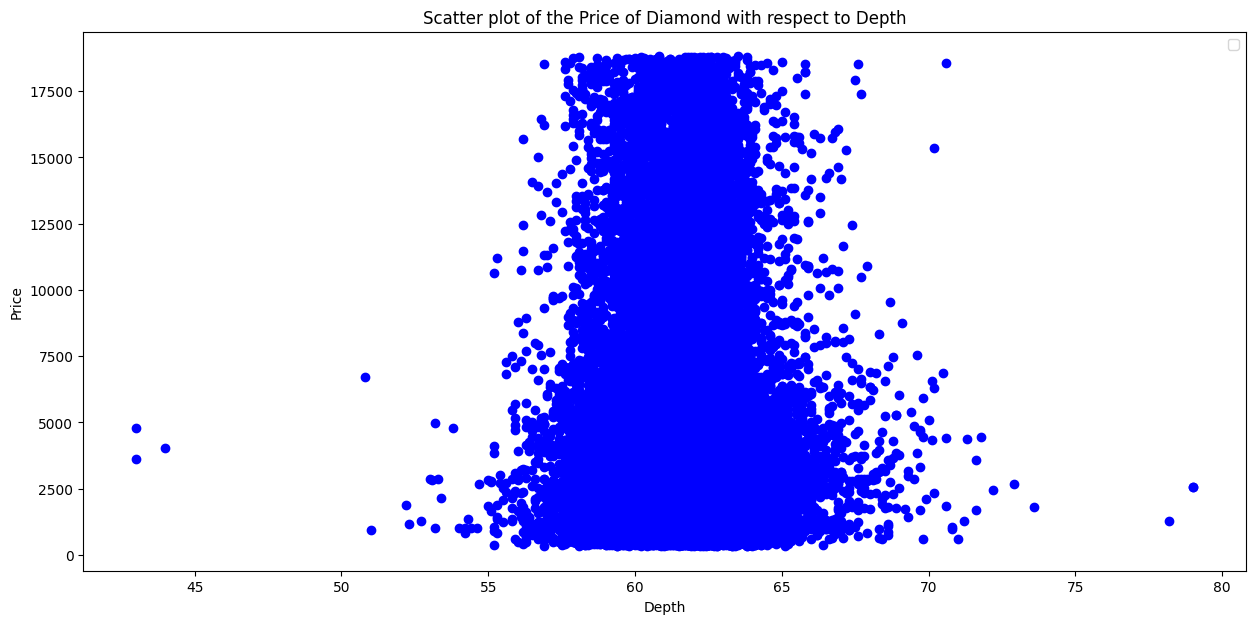

In [5]:
plot_scatter(column_name = 'depth', df = df, target = target)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


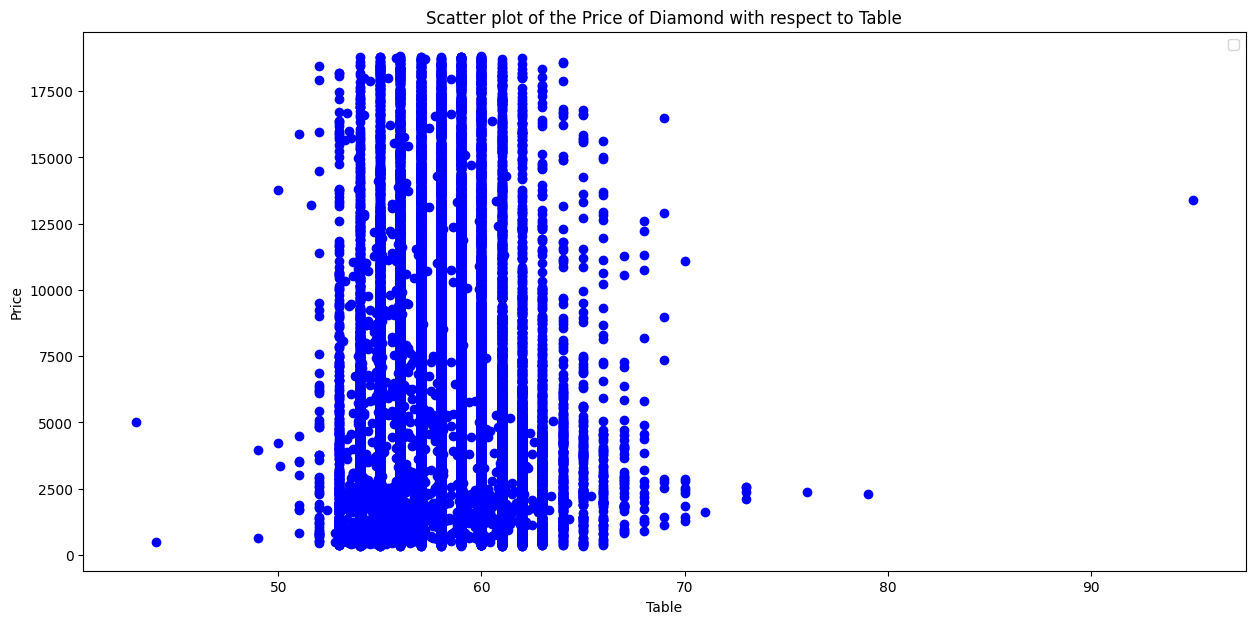

In [6]:
plot_scatter(column_name = 'table', df = df, target = target)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


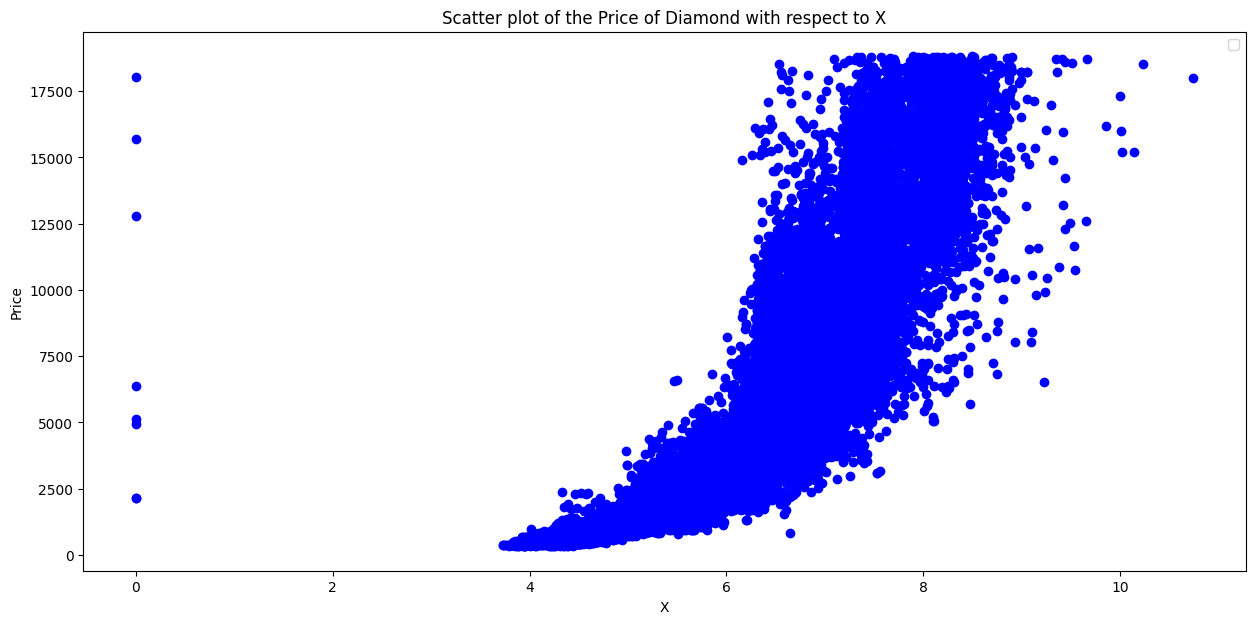

In [7]:
plot_scatter(column_name = 'x', df = df, target = target)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


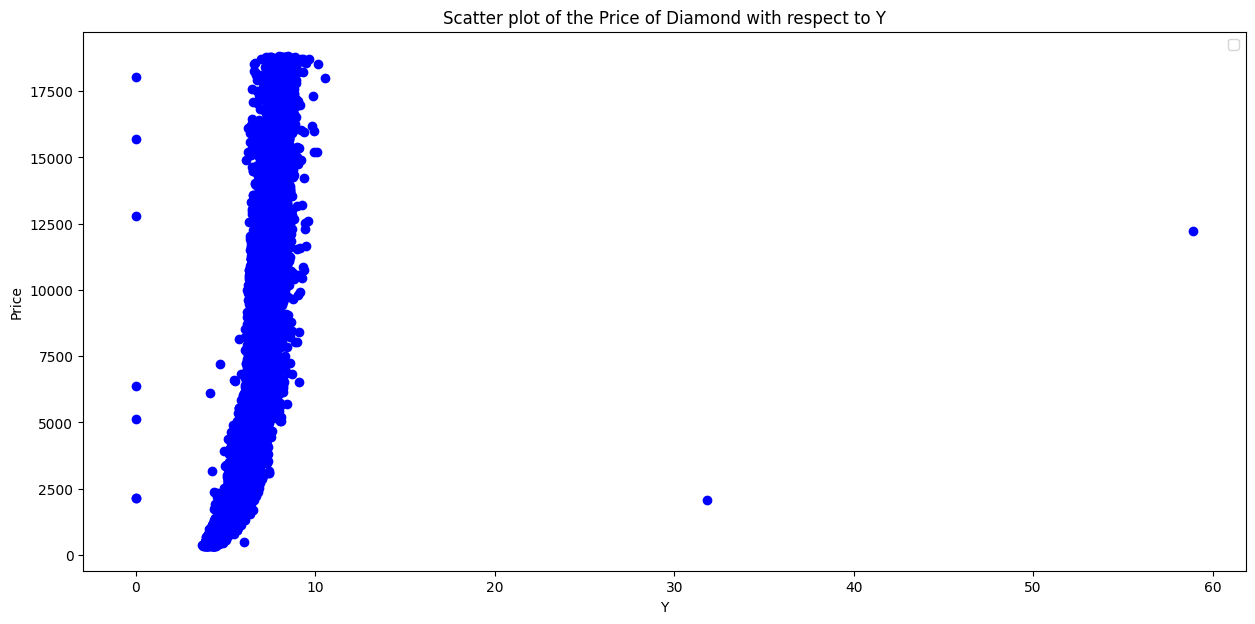

In [8]:
plot_scatter(column_name = 'y', df = df, target = target)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


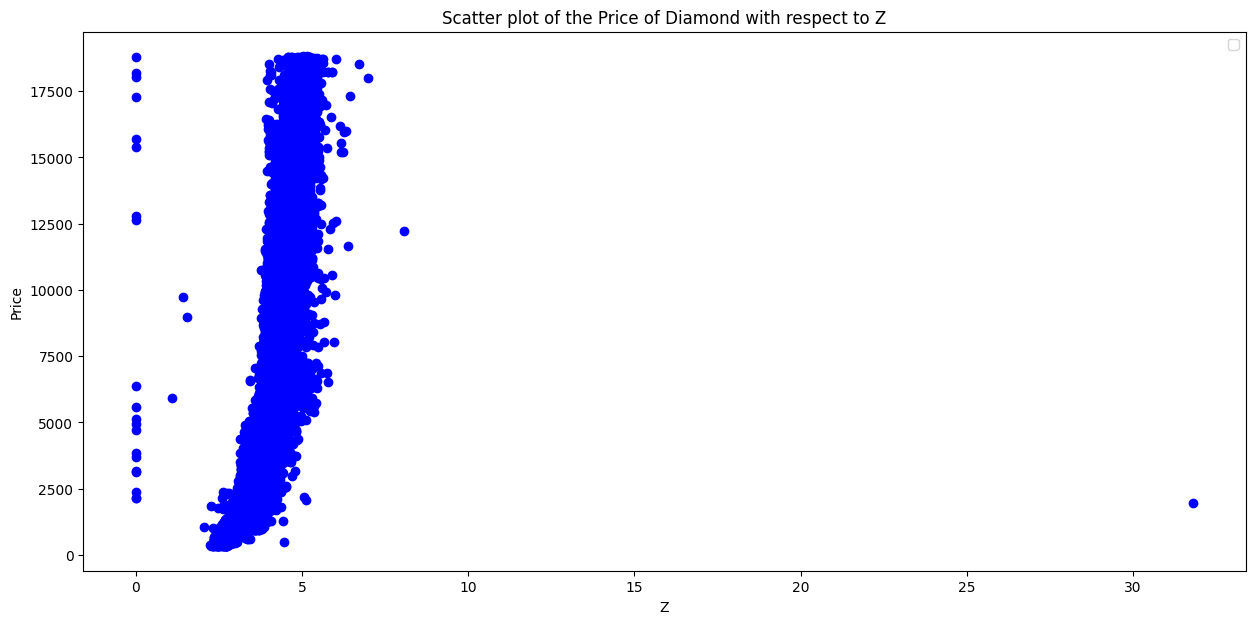

In [9]:
plot_scatter(column_name = 'z', df = df, target = target)

In the following, we are going to train a linear regression model to predict `price` using `carat` as the predictor using PyTorch.

In [10]:
# Import the necessary library
import torch

# Check if CUDA is available, else check for MPS, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else \
                      "mps" if torch.backends.mps.is_available() else \
                      "cpu")

# Define the dependent variable tensor 'y'. PyTorch uses tensors, which are a generalization of matrices to arbitrary dimensions.
# The '.values' attribute of 'target' returns a numpy array that contains the same data, but loses the pandas data structure.
# We then convert this array into a PyTorch tensor using 'torch.tensor()'. We make sure the data is in float format, which is required for our model.
# The tensor is moved to the device
y = torch.tensor(target.values).float().to(device)
y = y.view(y.shape[0], 1)

# Define the independent variable tensor 'X'. Similar to 'y', we convert the data in 'df['carat']' into a numpy array, then into a PyTorch tensor, and ensure it's in float format.
# The tensor is moved to the device
X = torch.tensor(df[['carat']].values).float().to(device)

# Define the linear regression model.
# 'torch.nn.Linear()' creates a linear regression model in PyTorch. The first argument is the number of input features (in this case, 1, since 'carat' is the only predictor),
# and the second argument is the number of output features (in this case, 1, since 'price' is the only target variable).
# The model is moved to the device
model = torch.nn.Linear(in_features = 1, out_features = 1).to(device)

# Define the loss function, which is the mean squared error (MSE).
loss_function = torch.nn.MSELoss()

# Define the optimization technique to be used. In this case, we use stochastic gradient descent (SGD).
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Training loop. We train the model for a certain number of epochs (iterations). An epoch is an iteration over the entire 'X' and 'y' data provided.
# We will cover what happens in a training loop in the next lab.
for epoch in range(5000):
    # Forward pass: compute predicted 'y' by passing 'X' to the model.
    y_pred = model(X)

    # Compute and print the loss.
    loss = loss_function(y_pred, y)
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss {loss.item()}')

    # Backward pass: compute gradient of the loss with respect to model parameters.
    loss.backward()

    # Perform a single optimization step (parameter update).
    optimizer.step()

    # Clear the gradients for the next iteration.
    optimizer.zero_grad()

# Print out the final loss and the model's parameters.
print(f'\nFinal loss: {loss.item()}')
print(f'Beta coefficients (weights): {model.weight.item()}')
print(f'Bias: {model.bias.item()}')

Epoch 0, Loss 31391046.0
Epoch 100, Loss 19944376.0
Epoch 200, Loss 14070315.0
Epoch 300, Loss 10988408.0
Epoch 400, Loss 9309019.0
Epoch 500, Loss 8337450.5
Epoch 600, Loss 7726242.5
Epoch 700, Loss 7301443.5
Epoch 800, Loss 6975826.5
Epoch 900, Loss 6705499.0
Epoch 1000, Loss 6468242.0
Epoch 1100, Loss 6252676.5
Epoch 1200, Loss 6052856.0
Epoch 1300, Loss 5865563.5
Epoch 1400, Loss 5688955.0
Epoch 1500, Loss 5521882.0
Epoch 1600, Loss 5363562.5
Epoch 1700, Loss 5213401.5
Epoch 1800, Loss 5070910.5
Epoch 1900, Loss 4935667.5
Epoch 2000, Loss 4807282.0
Epoch 2100, Loss 4685401.0
Epoch 2200, Loss 4569690.5
Epoch 2300, Loss 4459834.5
Epoch 2400, Loss 4355537.0
Epoch 2500, Loss 4256516.0
Epoch 2600, Loss 4162503.75
Epoch 2700, Loss 4073248.5
Epoch 2800, Loss 3988507.25
Epoch 2900, Loss 3908051.5
Epoch 3000, Loss 3831666.25
Epoch 3100, Loss 3759146.0
Epoch 3200, Loss 3690292.5
Epoch 3300, Loss 3624922.25
Epoch 3400, Loss 3562858.0
Epoch 3500, Loss 3503933.25
Epoch 3600, Loss 3447989.5
Epoc

This code trains a linear regression model to predict `price` using `carat` as the predictor. It uses PyTorch's `torch.nn.Linear` function to create the model and the Mean Squared Error (MSE) loss function for training. The model is trained using Stochastic Gradient Descent (SGD) for 5000 epochs. The final loss and the model's parameters (weights and bias) are then printed.

Make predictions for the tensor 'X' using `model(X).detach().numpy()`, and score the model (R-squared).

To calculate R-squared, first calculate the Total Sum of Squares (TSS) which measures the total variance in the response 'y'. Then calculate the Residual Sum of Squares (RSS) which measures the amount of variability that is left unexplained after performing the regression. Finally, calculate the R-squared score as `1 - (RSS/TSS)`.

Plot the predicted values against the true values of the target using matplotlib, and print the model R-squared.

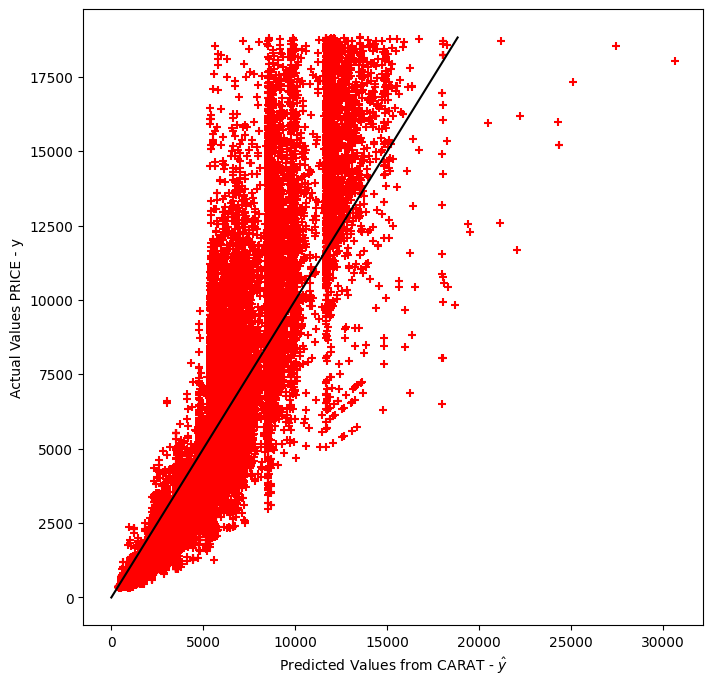

R-squared score:  0.8174309432506561


In [11]:
# Import the necessary library
import matplotlib.pyplot as plt

# Now that our model is trained, we can use it to make predictions.
# We pass our 'X' tensor, which contains the predictors, to our model.
# The model returns a tensor of predicted values.
# We move the model back to the CPU using the .cpu() method before making predictions.
# Also, the model returns a tensor on the same device as the input, so we move our predictions back to the CPU using the .cpu() method.
# We then convert the tensor to a numpy array using the .detach().numpy() methods.
# The .detach() method creates a tensor that shares storage with the original tensor, but with a new autograd history.
# This allows us to convert the tensor into a numpy array, which cannot hold torch.Tensor objects with require_grad=True.
# The numpy array, predictions, holds our predicted values.
predictions = model.cpu()(X.cpu()).detach().numpy()

# In order to calculate the R-squared score, we first need to calculate the Total Sum of Squares (TSS) and the Residual Sum of Squares (RSS).
# TSS measures the total variance in the response 'y', and RSS measures the amount of variability that is left unexplained after performing the regression.
# We calculate TSS as the sum of the square of the difference between each actual value in 'y' and the mean of 'y'.
# We calculate RSS as the sum of the square of the difference between each actual value in 'y' and the corresponding predicted value in 'predictions'.
TSS = np.sum((y.cpu().numpy() - np.mean(y.cpu().numpy()))**2)
RSS = np.sum((y.cpu().numpy() - predictions)**2)

# We then calculate the R-squared score as 1 - (RSS/TSS).
# The R-squared score, score, is a measure of how well our model predicts the response 'y'.
score = 1 - (RSS/TSS)

# Create a new figure with specified size in inches
fig, ax = plt.subplots(figsize=(8,8))

# Create a scatter plot of the actual values (y) against the predicted values (predictions).
# We set the size of the markers to 30, the color to red, the marker style to plus, and the z-order to 10.
# The z-order determines the order in which the markers are drawn on the plot. Markers with a higher z-order are drawn on top of markers with a lower z-order.
ax.scatter(predictions, y.cpu().numpy(), s=30, c='r', marker='+', zorder=10)

# Set the label for the x-axis
ax.set_xlabel("Predicted Values from CARAT - $\\hat{y}$")

# Set the label for the y-axis
ax.set_ylabel("Actual Values PRICE - y")

# Draw a line from (0,0) to (np.max(y), np.max(y)).
# This line represents a perfect prediction where every actual value is equal to its predicted value.
# Make sure it appears above the scatter points by using zorder.
ax.plot([0, np.max(y.cpu().numpy())], [0, np.max(y.cpu().numpy())], c = 'k', zorder = 15)

# Display the plot
plt.show()

# Print the R-squared score
print("R-squared score: ", score)

This plot provides insights into the performance of our model.

If the data points were perfectly aligned along the diagonal line, it would signify an ideal fit where all the predicted values are identical to the actual values. However, the more dispersed the data points are, resembling a cloud-like structure, the poorer the model's fit. This dispersion indicates significant discrepancies between the predicted and actual values in several instances.